Author: Seth Cram

Class: Deep Learning - CS474

Assignment: Final Project

## Dataset Content

The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

    sex: female or male
    age: of the patient.
    classification: covid_df test findings. Values 1-3 mean that the patient was diagnosed with covid_df in different
    degrees. 4 or higher means that the patient is not a carrier of covid_df or that the test is inconclusive.
    patient type: hospitalized or not hospitalized.
    pneumonia: whether the patient already have air sacs inflammation or not.
    pregnancy: whether the patient is pregnant or not.
    diabetes: whether the patient has diabetes or not.
    copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
    asthma: whether the patient has asthma or not.
    inmsupr: whether the patient is immunosuppressed or not.
    hypertension: whether the patient has hypertension or not.
    cardiovascular: whether the patient has heart or blood vessels related disease.
    renal chronic: whether the patient has chronic renal disease or not.
    other disease: whether the patient has other disease or not.
    obesity: whether the patient is obese or not.
    tobacco: whether the patient is a tobacco user.
    usmr: Indicates whether the patient treated medical units of the first, second or third level.
    medical unit: type of institution of the National Health System that provided the care.
    intubed: whether the patient was connected to the ventilator.
    icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
    death: indicates whether the patient died or recovered.


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report
import shap
from sklearn.utils import class_weight
import keras.backend as K

c:\Users\crazy\source\repos\CS474-Deep-Learning\JupyterNotebook\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
covid_df = pd.read_csv("Covid Data.csv")

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Data Preprocessing

In [4]:
#only keep covid_df positive patient data
covid_df = covid_df.loc[(covid_df.CLASIFFICATION_FINAL < 4)]
#Cleaning the data to keep only the rows containing 1, 2
covid_df = covid_df[(covid_df.OBESITY == 1) | (covid_df.OBESITY == 2)] #uses bitwise OR
covid_df = covid_df[(covid_df.RENAL_CHRONIC == 1) | (covid_df.RENAL_CHRONIC == 2)]
covid_df = covid_df[(covid_df.TOBACCO == 1) | (covid_df.TOBACCO == 2)]
covid_df = covid_df[(covid_df.PNEUMONIA == 1) | (covid_df.PNEUMONIA == 2)] 
covid_df = covid_df[(covid_df.DIABETES == 1) | (covid_df.DIABETES == 2)]
covid_df = covid_df[(covid_df.COPD == 1) | (covid_df.COPD == 2)]
covid_df = covid_df[(covid_df.ASTHMA == 1) | (covid_df.ASTHMA == 2)]
covid_df = covid_df[(covid_df.INMSUPR == 1) | (covid_df.INMSUPR == 2)]
covid_df = covid_df[(covid_df.HIPERTENSION == 1) | (covid_df.HIPERTENSION == 2)]
covid_df = covid_df[(covid_df.OTHER_DISEASE == 1) | (covid_df.OTHER_DISEASE == 2)]
covid_df = covid_df[(covid_df.CARDIOVASCULAR == 1) | (covid_df.CARDIOVASCULAR == 2)]

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97


In [5]:
#copy df to preserve death date info
visualization_df = covid_df.copy(deep=True)

#if death date given, mark it as 1, else 0
covid_df.DATE_DIED = covid_df.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1) #ruins data visualization
#if data missing, mark it as a 0
covid_df.INTUBED = covid_df.INTUBED.apply(lambda x: x if x == 1 else 0)                   
covid_df.ICU = covid_df.ICU.apply(lambda x: x if x == 1 else 0)

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,0,1,65,2,2,...,2,2,1,2,2,2,2,2,3,0
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,0
4,2,1,2,1,1,0,2,68,97,1,...,2,2,1,2,2,2,2,2,3,0
5,2,1,1,2,0,0,1,40,2,2,...,2,2,2,2,2,2,2,2,3,0
6,2,1,1,1,0,0,2,64,2,2,...,2,2,2,2,2,2,2,2,3,0


In [6]:
#create the at risk column
covid_df['HIGH_RISK'] = covid_df['DATE_DIED'] + covid_df['INTUBED'] + covid_df['ICU']
covid_df.HIGH_RISK = covid_df.HIGH_RISK.apply(lambda x: 1 if x > 0 else 0) 

#columns no longer useful bc: 
# all patients are now covid positive 
# the rest of the columns are repped by the at risk column now 
covid_df.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED', 'ICU', 'DATE_DIED'], inplace=True)

print(f"{100*(covid_df.HIGH_RISK.value_counts()[0]/len(covid_df.HIGH_RISK))}% of the data isn't high risk")

covid_df.head()

84.57639671053646% of the data isn't high risk


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,HIGH_RISK
0,2,1,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2,1
2,2,1,2,2,2,55,97,1,2,2,2,2,2,2,2,2,2,1
4,2,1,2,1,2,68,97,1,2,2,2,1,2,2,2,2,2,1
5,2,1,1,2,1,40,2,2,2,2,2,2,2,2,2,2,2,0
6,2,1,1,1,2,64,2,2,2,2,2,2,2,2,2,2,2,0


In [7]:
print(covid_df.PREGNANT.value_counts())

#98 = female not pregnant, set to 2 for not pregnant
covid_df.PREGNANT = covid_df.PREGNANT.replace(98, 2)
#97 = men, set to 2 for not pregnant
covid_df.PREGNANT = covid_df.PREGNANT.replace(97, 2)

print(covid_df.PREGNANT.value_counts())

97    207594
2     177258
1       2744
98      1282
Name: PREGNANT, dtype: int64
2    386134
1      2744
Name: PREGNANT, dtype: int64


In [8]:
#drop targets from x and set them as y
Y = covid_df["HIGH_RISK"] 
covid_df = covid_df.drop("HIGH_RISK", axis = 1)
X = covid_df 

print(f"x shape: {X.shape}, y shape: {Y.shape}")

display(covid_df.head())

#split data into training and test
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0) #rand state so same rando shuffle
#create validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x shape: (388878, 17), y shape: (388878,)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,2,1,1,1,1,65,2,2,2,2,2,1,2,2,2,2,2
2,2,1,2,2,2,55,2,1,2,2,2,2,2,2,2,2,2
4,2,1,2,1,2,68,2,1,2,2,2,1,2,2,2,2,2
5,2,1,1,2,1,40,2,2,2,2,2,2,2,2,2,2,2
6,2,1,1,1,2,64,2,2,2,2,2,2,2,2,2,2,2


x_train shape: (217771, 17), y_train shape: (217771,)
x_val shape: (54443, 17), y_val shape: (54443,)
x_test shape: (116664, 17), y_test shape: (116664,)


## Data Visualization

In [9]:
#die date vars created 
visualization_df["MONTH"] = visualization_df.DATE_DIED.str.split("/", expand = True)[1]
visualization_df["YEAR"] = visualization_df.DATE_DIED.str.split("/", expand = True)[2]

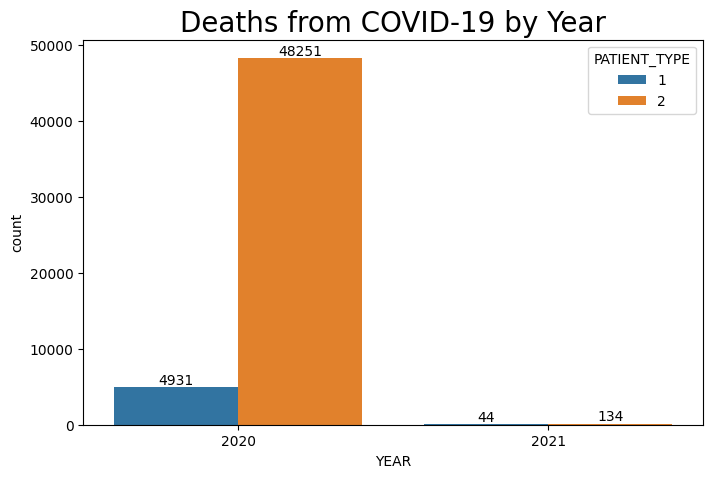

In [10]:
#count number of patients died each year by patient type (1=not hopitalized, 2=hospitalized)
plt.figure(figsize = (8,5))
ax = sns.countplot(x = "YEAR", hue = "PATIENT_TYPE", data = visualization_df)
plt.title("Deaths from COVID-19 by Year", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)

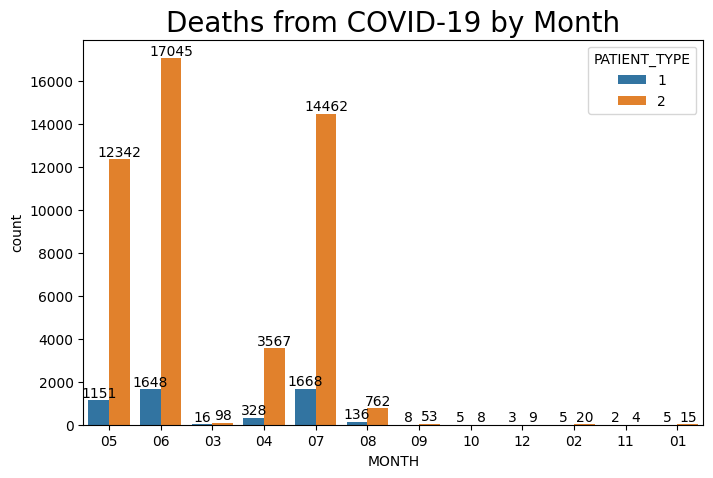

In [11]:
#months ppl most died in
plt.figure(figsize = (8,5))
ax = sns.countplot(x = "MONTH", hue = "PATIENT_TYPE", data = visualization_df)
plt.title("Deaths from COVID-19 by Month", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)

## Model Classifier

### Optional Model Restore

In [97]:
model = tf.keras.models.load_model("saved_models/" + "Custom_fcn15_10_5_10_15_89.2test_66.7f1")

model.summary(expand_nested=True, show_trainable=True)

filename = "Custom_fcn15_10_5_10_15v2"

Model: "model_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 17)]              0         Y          
                                                                            
 dense_12 (Dense)            (None, 15)                270       Y          
                                                                            
 dense_13 (Dense)            (None, 10)                160       Y          
                                                                            
 dense_14 (Dense)            (None, 5)                 55        Y          
                                                                            
 dense_15 (Dense)            (None, 10)                60        Y          
                                                                            
 dense_16 (Dense)            (None, 15)                165 

### Create Model

In [12]:
filename = "Custom_fcn_f1score_weighted_15_10_5_10_15"

input = tf.keras.layers.Input(x_train.shape[1])
x = tf.keras.layers.Dense(
    units=15,
    activation="relu"
)(input)
x = tf.keras.layers.Dense(
    units=10,
    activation="relu"
)(x)
x = tf.keras.layers.Dense(
    units=5,
    activation="relu"
)(x)
x = tf.keras.layers.Dense(
    units=10,
    activation="relu"
)(x)
x = tf.keras.layers.Dense(
    units=15,
    activation="relu"
)(x)
preds = tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.sigmoid 
)(x)
model = tf.keras.Model(input, preds)

model.summary(expand_nested=True, show_trainable=True)


Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_1 (InputLayer)        [(None, 17)]              0         Y          
                                                                            
 dense (Dense)               (None, 15)                270       Y          
                                                                            
 dense_1 (Dense)             (None, 10)                160       Y          
                                                                            
 dense_2 (Dense)             (None, 5)                 55        Y          
                                                                            
 dense_3 (Dense)             (None, 10)                60        Y          
                                                                            
 dense_4 (Dense)             (None, 15)                165   

In [13]:
#need recall to calc f1 score
def recall_score(y_true, y_pred):
    #needa use tensor ops instead of numpy
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

#need precision to calc f1 score
def precision_score(y_true, y_pred):
    #needa use tensor ops instead of numpy
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [14]:
#compute class weight from unbalanced dataset
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y_train), 
        y=y_train
    )
class_weights = dict(enumerate(class_weights))

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), #learning_rate=lr_scheduler #RMSprop()
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=[f1_score],
)

In [16]:
#callbacks
logger_callback = tf.keras.callbacks.CSVLogger(
    filename="model_logs/" + filename + '.csv',
    separator=',',
    append=True #don't overwrite if file exists already
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1_score", #"val_accuracy",
    min_delta=0.0001,
    patience=100,
    verbose=1,
    restore_best_weights=True,
    mode='max'
)

#model training
history = model.fit(
    x_train, 
    y_train, 
    epochs=300, #100
    validation_data=(x_val, y_val), 
    shuffle=True, #shuffles data after every epoch to reduce overfitting
    callbacks=[logger_callback, early_stopping_callback, ],
    class_weight=class_weights,
    workers=4,
    use_multiprocessing = True,
)

Epoch 1/300
6806/6806 [==============================] - 11s 1ms/step - loss: 0.3113 - f1_score: 0.6287 - val_loss: 0.3547 - val_f1_score: 0.6387
Epoch 2/300
1091/6806 [===>..........................] - ETA: 7s - loss: 0.2939 - f1_score: 0.6379

KeyboardInterrupt: 

## Results Metrics

In [17]:
#predict y
yPred = np.round(model.predict(x_test)).flatten()
print(yPred.shape)

3646/3646 [==============================] - 3s 842us/step
(116664,)


In [18]:
#Accuracy
print(f"Model inbalanced test accuracy = {accuracy_score(yPred, y_test)}")
#create sample weights from class weights 
sample_weights = [class_weights[target] for target in y_test]
print(f"Model balanced test accuracy = {accuracy_score(yPred, y_test, sample_weight=sample_weights)}")

print(f1_score(y_test.astype('float32'), yPred))
print('\n', classification_report(y_test, yPred)) #most lacking in macro avg, f1-score on 1's

Model inbalanced test accuracy = 0.8569653020640472
Model balanced test accuracy = 0.8911430142166421
tf.Tensor(0.6706664, shape=(), dtype=float32)

               precision    recall  f1-score   support

           0       0.99      0.84      0.91     98591
           1       0.52      0.94      0.67     18073

    accuracy                           0.86    116664
   macro avg       0.75      0.89      0.79    116664
weighted avg       0.91      0.86      0.87    116664



## Training Plots

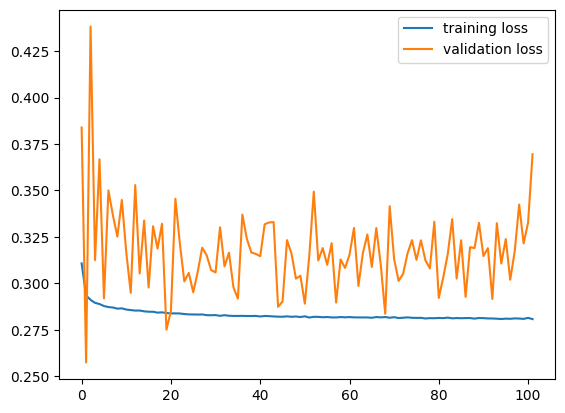

In [56]:
#history of training and validation loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

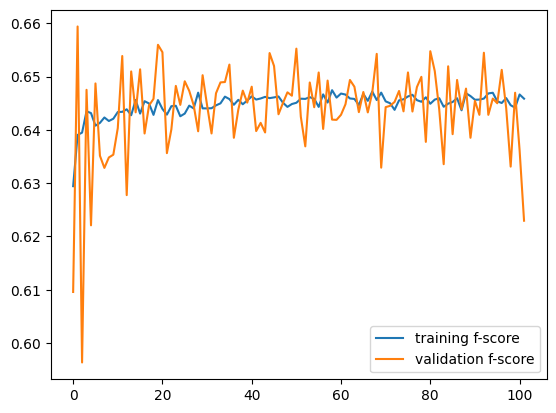

In [58]:
#history of training and validation f-score
plt.plot(history.history['f1_score'], label='training f-score')
plt.plot(history.history['val_f1_score'], label='validation f-score')
plt.legend()
plt.show()

## Feature Importance

In [59]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(model, shap.sample(x_test, 1))
shap_values = explainer.shap_values(x_test)

 22%|██▏       | 26008/116664 [03:47<12:54, 117.12it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 26%|██▌       | 29789/116664 [04:20<12:38, 114.47it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeli

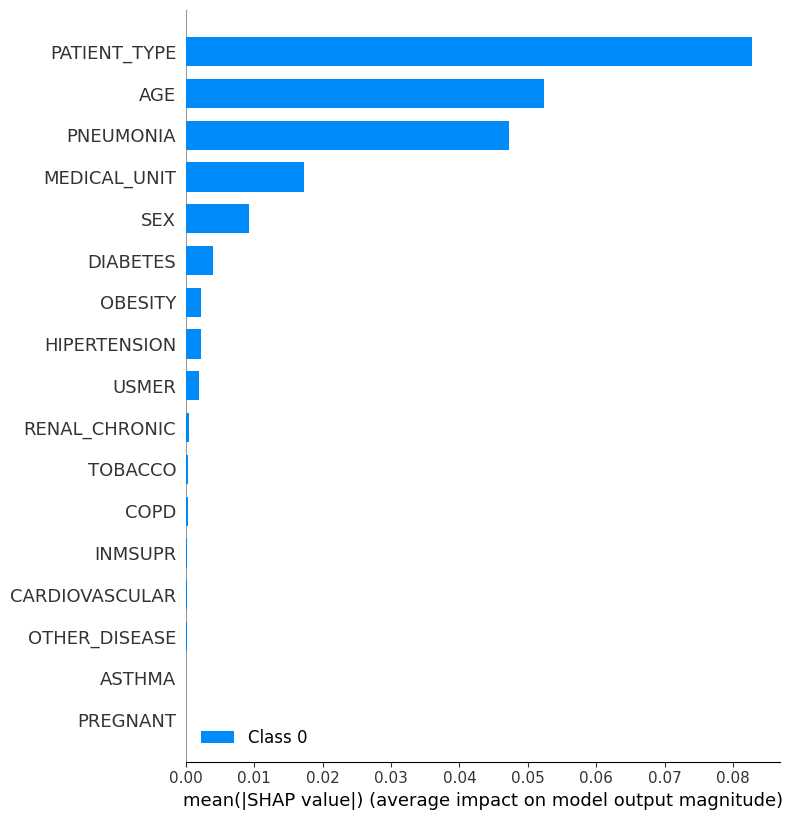

In [69]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], feature_names=covid_df.columns) #want titles as last arg
shap.summary_plot(shap_values, X, plot_type="bar")

## Save Model

In [159]:
model.save("saved_models/" + filename + "_89.3btest_66f1") 

INFO:tensorflow:Assets written to: saved_models/Custom_fcn_f1score_15_10_5_10_15_89.3btest_66f1\assets
